<a href="https://colab.research.google.com/github/m-restrepo11/news_classification/blob/master/W%26J.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.style.use('seaborn-darkgrid')

# Load data and data wrangling

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!ls ~/.kaggle
#
#!pip install -q kaggle
#!pip install -q kaggle-cli
#!kaggle datasets download -d rmisra/news-category-dataset # api copied from kaggle
#!unzip *.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_json('/content/drive/My Drive/W&J/News_Category_Dataset_v2.json', lines=True)

In [4]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [5]:
df[df.authors == ''].count()

authors              36620
category             36620
date                 36620
headline             36620
link                 36620
short_description    36620
dtype: int64

In [6]:
df[df.short_description == ''].count()

authors              19712
category             19712
date                 19712
headline             19712
link                 19712
short_description    19712
dtype: int64

In [7]:
df.describe()

,authors,category,date,headline,link,short_description
count,200853,200853,200853,200853,200853,200853
unique,27993,41,2309,199344,200812,178353
top,,POLITICS,2013-01-17 00:00:00,Sunday Roundup,https://www.huffingtonpost.comhttp://www.nytim...,
freq,36620,32739,100,90,2,19712
first,NaN,NaN,2012-01-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-05-26 00:00:00,NaN,NaN,NaN


In [8]:
df[(df['authors'] == '')  | (df['short_description'] == '' ) | (df['headline'] == '' )].groupby(by='category').size().sum()

51870

In [0]:
df.drop(df[(df['authors'] == '') | (df['short_description'] == '' ) | (df['headline'] == '' )].index, inplace=True)

WORLDPOST and THE WORLDPOST should be a single category.

In [0]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

Add a column with all the text of the data, i.e. the headline and the short description.

In [0]:
df['news_text'] =  df[['headline', 'short_description']].apply(lambda x: ' '.join(x), axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148983 entries, 0 to 200848
Data columns (total 7 columns):
authors              148983 non-null object
category             148983 non-null object
date                 148983 non-null datetime64[ns]
headline             148983 non-null object
link                 148983 non-null object
short_description    148983 non-null object
news_text            148983 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 9.1+ MB


# Exploratory data analysis

## Categories

In [13]:
df.groupby('category').size().sort_values(ascending=False)

category
POLITICS          26913
WELLNESS          12827
ENTERTAINMENT     12192
TRAVEL             8011
STYLE & BEAUTY     7111
PARENTING          6408
HEALTHY LIVING     5072
QUEER VOICES       4669
FOOD & DRINK       4413
BUSINESS           4320
COMEDY             3709
PARENTS            3491
SPORTS             3445
WORLDPOST          3440
HOME & LIVING      3398
BLACK VOICES       3260
IMPACT             2920
WOMEN              2840
MEDIA              1976
CRIME              1960
TASTE              1891
WEIRD NEWS         1890
WORLD NEWS         1824
RELIGION           1761
WEDDINGS           1703
DIVORCE            1695
GREEN              1682
TECH               1659
STYLE              1535
MONEY              1492
SCIENCE            1404
ARTS & CULTURE     1307
FIFTY              1042
GOOD NEWS           917
EDUCATION           885
LATINO VOICES       877
ARTS                863
COLLEGE             860
ENVIRONMENT         670
CULTURE & ARTS      651
dtype: int64

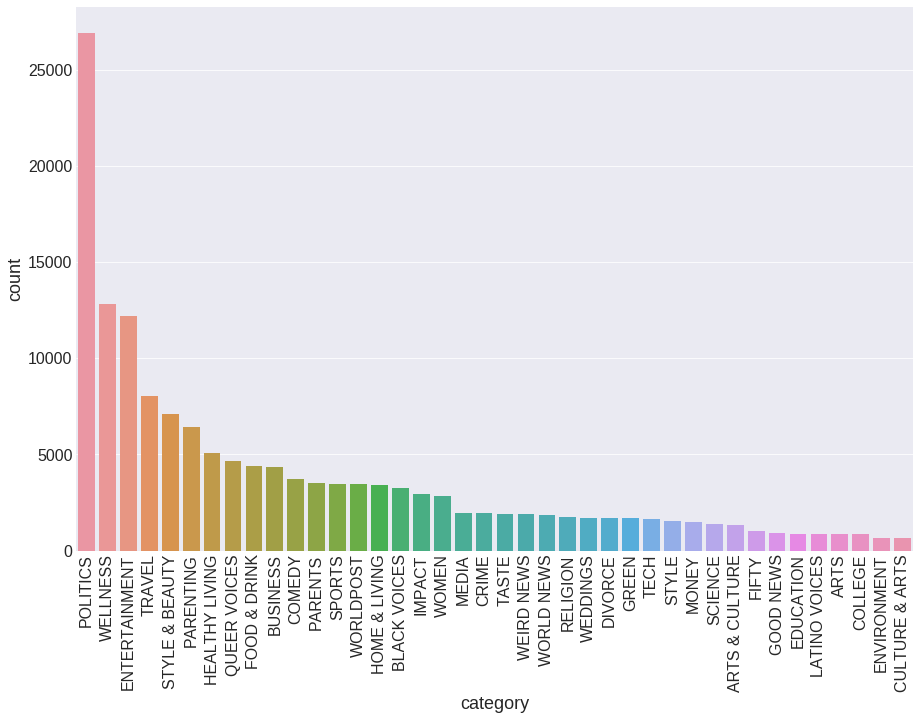

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(x = 'category', data = df,  order = df['category'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

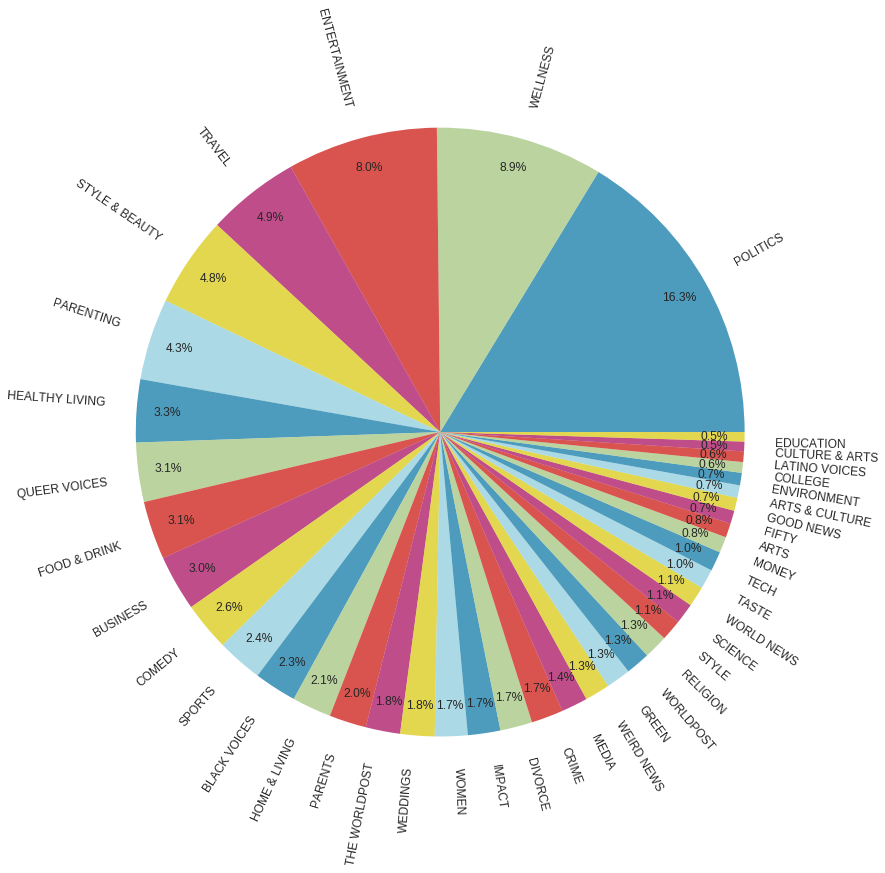

In [161]:
plt.figure(figsize=(14,14))
df['category'].value_counts().plot.pie( autopct = '%1.1f%%', rotatelabels=True,  textprops={'fontsize': 12}, pctdistance=0.9,  wedgeprops={'alpha':0.7})
plt.ylabel('')
plt.show()


Notice that the 10 most common categories account for more than 50% of the news. This information can be useful farther along in the development of our models. However, I believe we should focus in this top 10 categories as a first approach in order to have the most frequent a most clearly defined categories to work with. **Note however we can easily generalize all results to include all categories.** Hereafter, I will refere to the dataset as this top 10 category subset.

In [0]:
df = df[(df.category == 'POLITICS') | (df.category == 'WELLNESS') |(df.category == 'ENTERTAINMENT') 
        |(df.category == 'TRAVEL') |(df.category == 'STYLE & BEAUTY') |(df.category == 'PARENTING') 
        |(df.category == 'HEALTHY LIVING') |(df.category == 'QUEER VOICES') |(df.category == 'FOOD & DRINK') |(df.category == 'BUSINESS')]


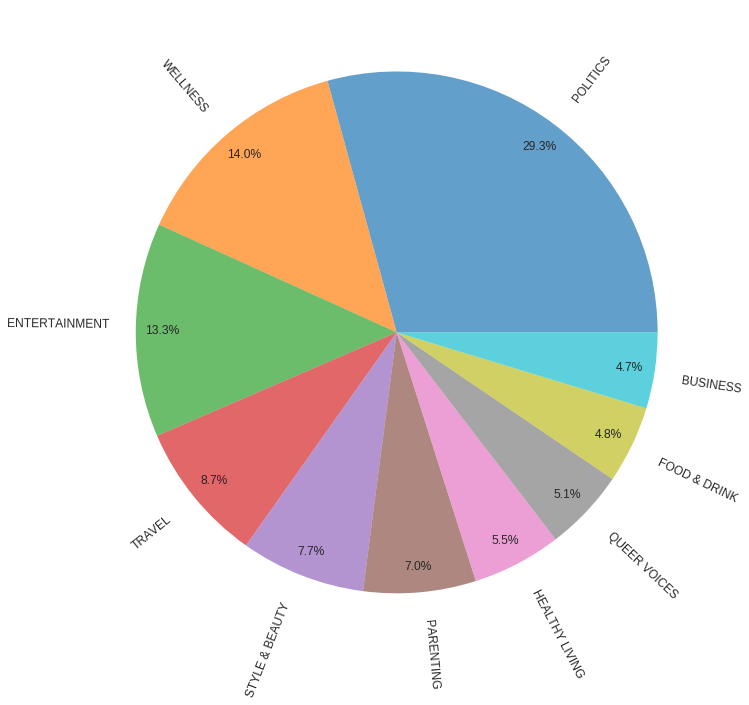

In [17]:
plt.figure(figsize=(12,12))
df['category'].value_counts().plot.pie( autopct = '%1.1f%%', rotatelabels=True,  textprops={'fontsize': 12}, pctdistance=0.9,  wedgeprops={'alpha':0.7})
plt.ylabel('')
plt.show()


In the previous pie chart we can see the category distribution after selecting the top 10 categories.

### Word clouds

Let us generate the worldclouds of all the dataset (headline + description) and the four most prominent categories to have a visual clue of the most frequent words given each category.


In [0]:
def generate_wordcloud(text):
    wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
    
    return wordcloud

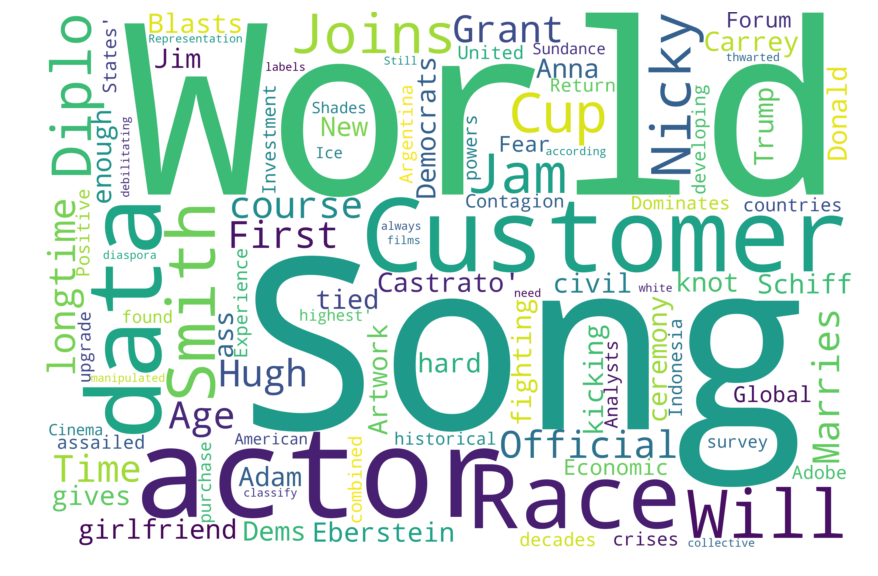

In [19]:
text = df.news_text.values

fig = plt.figure(figsize = (12, 12))

plt.imshow(generate_wordcloud(text), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

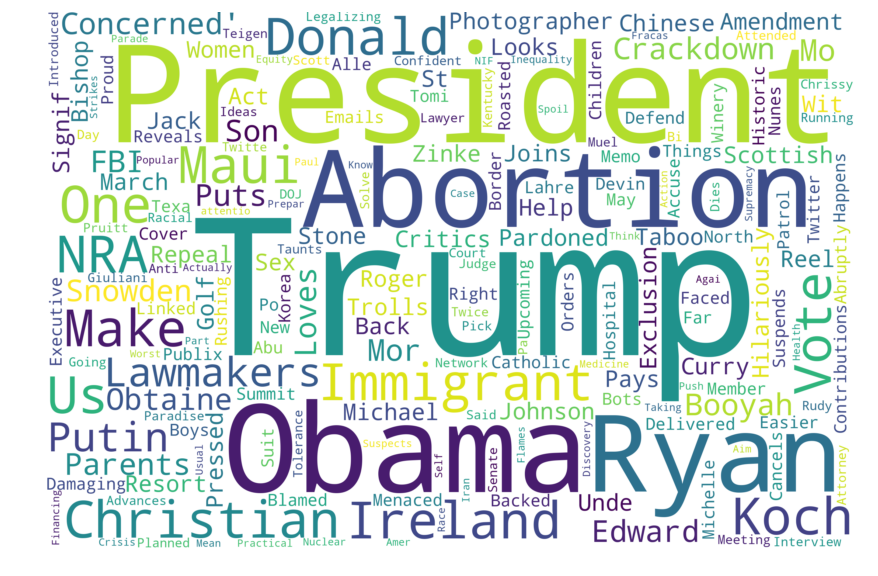

In [20]:
text = df[df.category == 'POLITICS']['news_text']

fig = plt.figure(figsize = (12, 12))
plt.imshow(generate_wordcloud(text), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

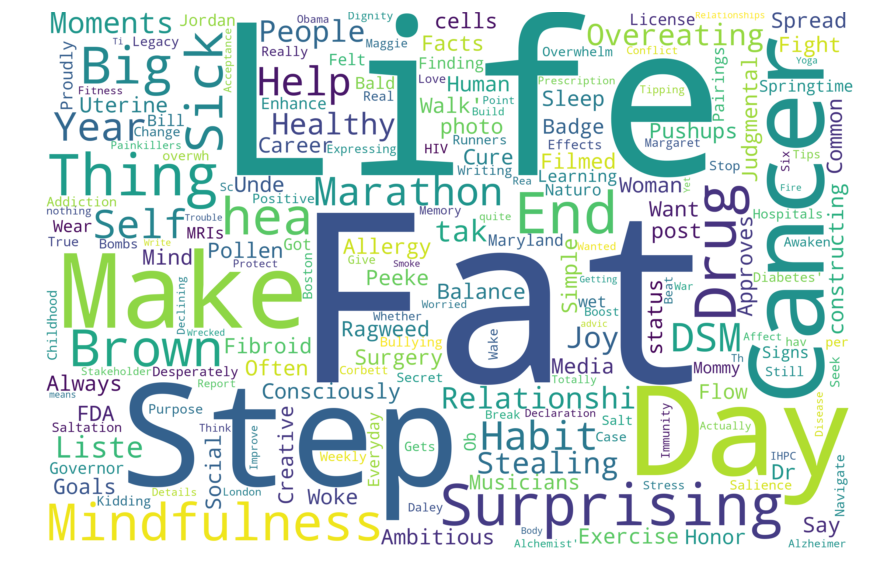

In [21]:
text = df[df.category == 'WELLNESS']['news_text']

fig = plt.figure(figsize = (12, 12))
plt.imshow(generate_wordcloud(text), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

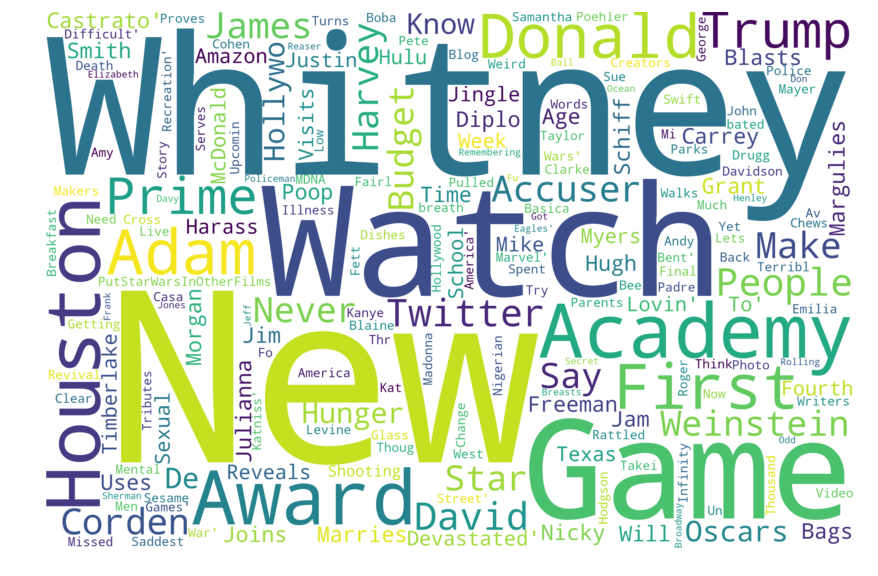

In [22]:
text = df[df.category == 'ENTERTAINMENT']['news_text']

fig = plt.figure(figsize = (12, 12))
plt.imshow(generate_wordcloud(text), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

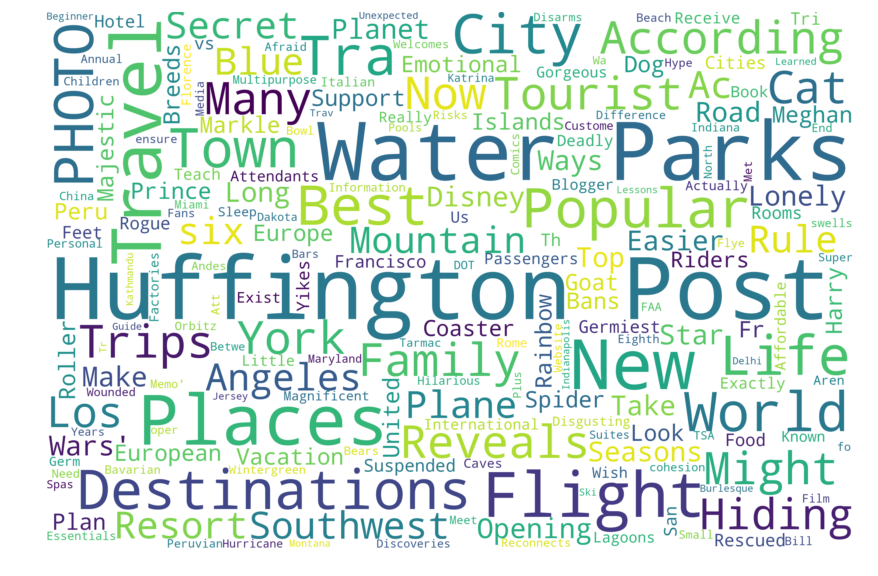

In [23]:
text = df[df.category == 'TRAVEL']['news_text']

fig = plt.figure(figsize = (12, 12))
plt.imshow(generate_wordcloud(text), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Authors

In [24]:
total_authors = df.authors.nunique()
total_news = df.shape[0]
threshold = 240
news_pctg = df.authors.value_counts()[:threshold].sum()/ total_news *100

print('Total number of authors : ', total_authors)
print('Mean number of articles written by per author: ' + str(total_news//total_authors))
print('The top {0:} authors wrote {1:} articles out of a total of {2:} articles. Put another way, {3:.2f}% of authors account for {4:.2f}% of all articles written.'.format(
threshold, df.authors.value_counts()[:threshold].sum(), df.shape[0],(threshold/total_authors)*100, news_pctg))

Total number of authors :  16101
Mean number of articles written by per author: 5
The top 240 authors wrote 46314 articles out of a total of 91936 articles. Put another way, 1.49% of authors account for 50.38% of all articles written.


As we can see from the previous cell the vast majority of articles are written by a  very small minority of authors.

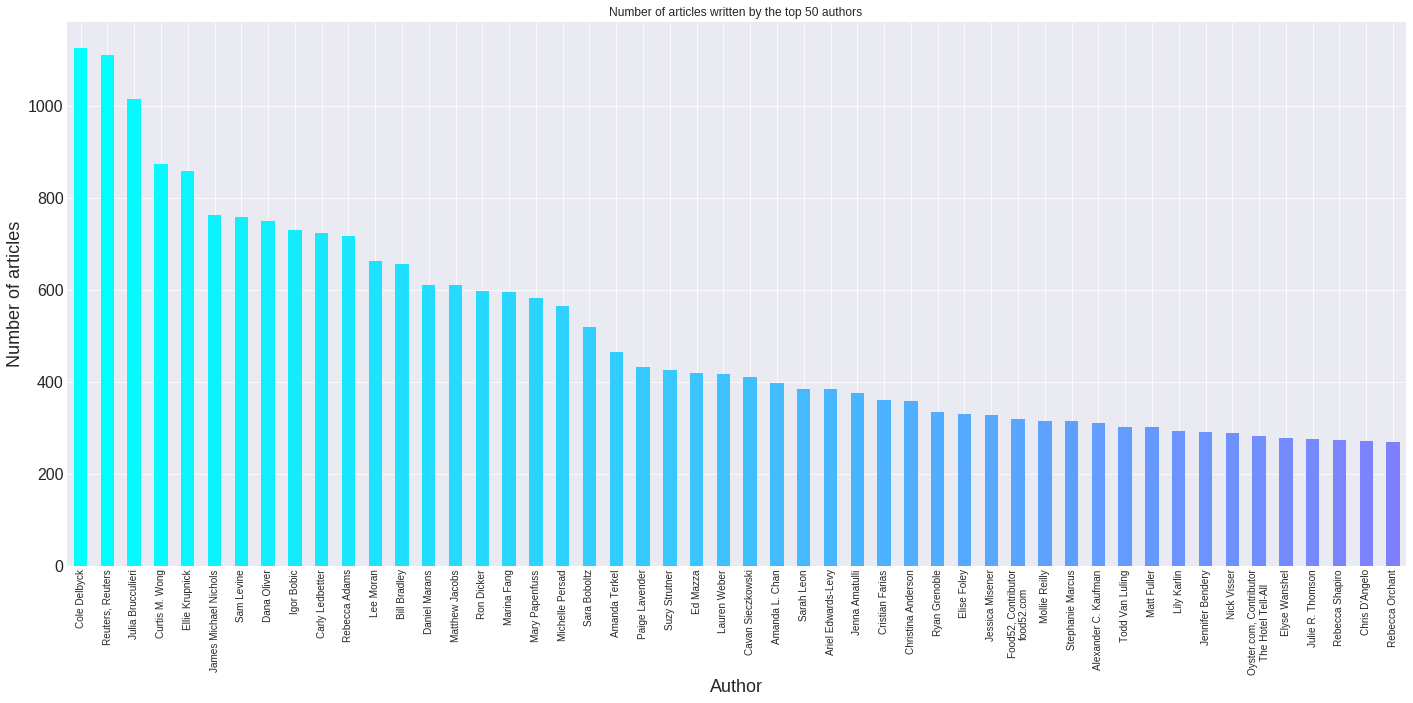

In [25]:
plt.figure(figsize=(24,10))
color = plt.cm.cool(np.linspace(0,1,100))
df.authors.value_counts()[:50].plot.bar(color=color)
plt.xticks(fontsize=10)
plt.xlabel('Author')
plt.ylabel('Number of articles')
plt.title('Number of articles written by the top 50 authors ')
plt.show()

In [26]:
df.authors.value_counts()[:10]

Cole Delbyck             1126
Reuters, Reuters         1111
Julia Brucculieri        1014
Curtis M. Wong            874
Ellie Krupnick            859
James Michael Nichols     762
Sam Levine                759
Dana Oliver               749
Igor Bobic                730
Carly Ledbetter           724
Name: authors, dtype: int64

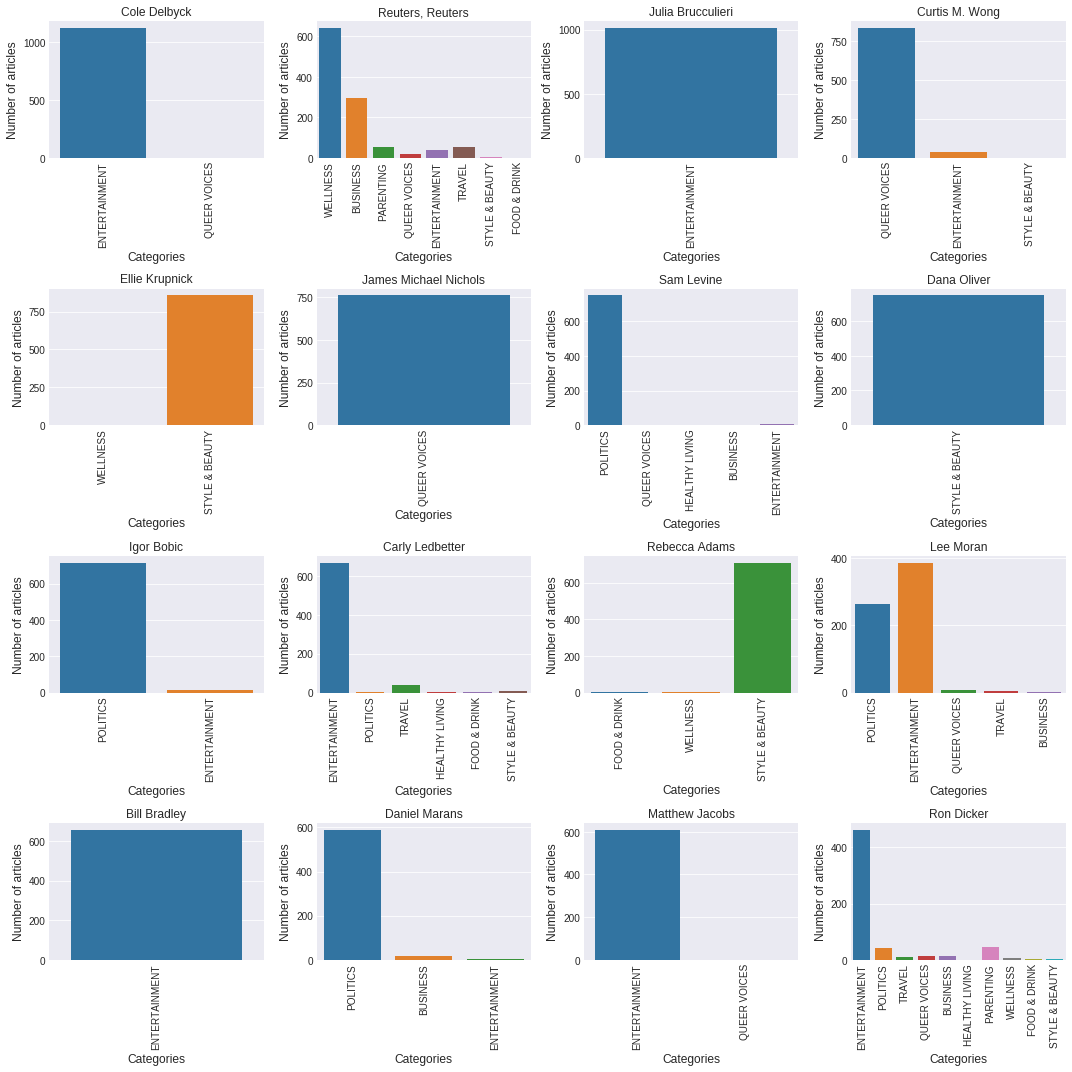

In [27]:
top10_authors = df.authors.value_counts()[:16].index.tolist()

plt.figure(figsize=(15,15))
k = 1
for author in top10_authors:    
    particular_author_news = df[df['authors'] == author]
    plt.subplot(4,4,k)
    sns.countplot(x = particular_author_news.category, data=df)
    plt.xlabel('Categories',fontsize=12)
    plt.ylabel('Number of articles',fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(author)
    plt.tight_layout()
    k += 1
plt.show()



Note that most individual authors (i.e. not Reuters which is an agency) have a very defined writing niche, that is they write the 
overwhelming majority of their articles in a single category. Of course there are some exceptions to this trend, as seen for example in the case of Lee Moran whose niche is composed by two categories. This leads me to believe that author might be used as a feature in the category classification.

## Date

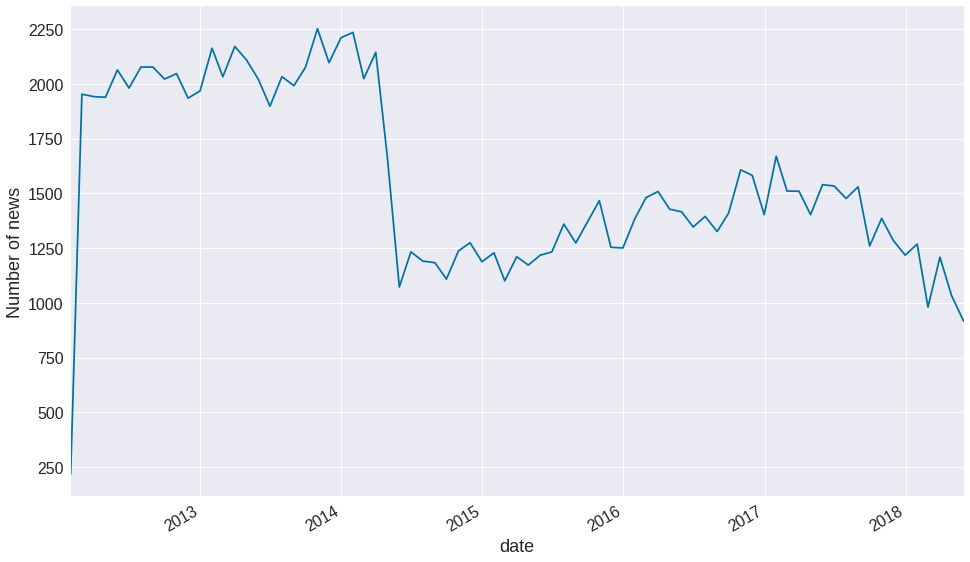

In [165]:
plt.figure(figsize=(16,10))
df.groupby(pd.Grouper(key='date', freq='M'))['date'].count().sort_values(ascending=False).plot()
plt.ylabel('Number of news')
plt.show()

In [29]:
df.groupby(pd.Grouper(key='date', freq='3M'))['category'].agg(lambda x:x.value_counts().index[0])

date
2012-01-31    STYLE & BEAUTY
2012-04-30    STYLE & BEAUTY
2012-07-31          WELLNESS
2012-10-31          WELLNESS
2013-01-31          WELLNESS
2013-04-30          WELLNESS
2013-07-31          WELLNESS
2013-10-31          WELLNESS
2014-01-31          WELLNESS
2014-04-30          WELLNESS
2014-07-31          POLITICS
2014-10-31          POLITICS
2015-01-31          POLITICS
2015-04-30          POLITICS
2015-07-31          POLITICS
2015-10-31          POLITICS
2016-01-31          POLITICS
2016-04-30          POLITICS
2016-07-31          POLITICS
2016-10-31          POLITICS
2017-01-31          POLITICS
2017-04-30          POLITICS
2017-07-31          POLITICS
2017-10-31          POLITICS
2018-01-31          POLITICS
2018-04-30          POLITICS
2018-07-31          POLITICS
Freq: 3M, Name: category, dtype: object

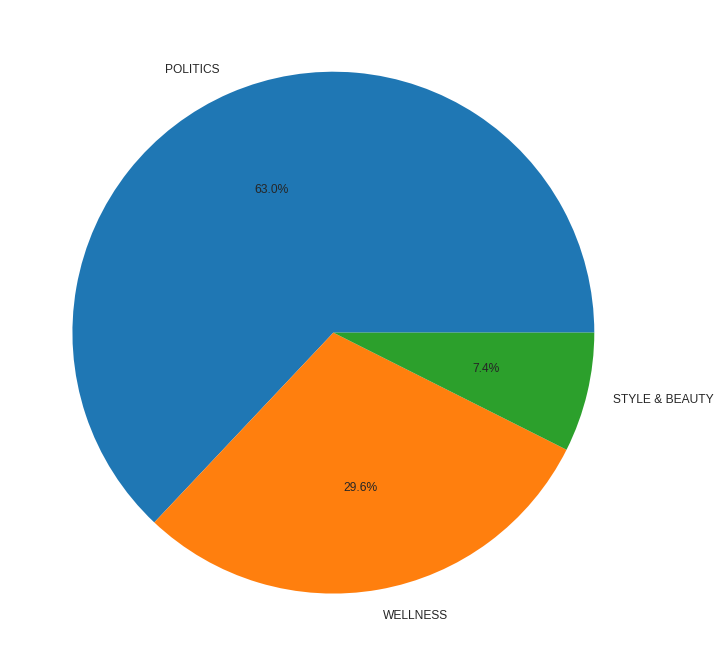

In [30]:
plt.figure(figsize=(12,12))
df.groupby(pd.Grouper(key='date', freq='3M'))['category'].agg(lambda x:x.value_counts().index[0]).value_counts().plot.pie(autopct = '%1.1f%%', textprops={'fontsize': 12})
plt.ylabel('')
plt.show()

In the previous cells we can see some of the historical data related to the news and the distribution of articles and categories written by month.

# Models

## Preliminary exploration of some calssification algorithms

In [0]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  train_test_split
from sklearn.decomposition import  TruncatedSVD
from sklearn.manifold import TSNE
categories = df.category.unique()

In [0]:
X = df.news_text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Naive Bayes

In [130]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'word', max_features = 30000,
                                         stop_words='english', lowercase =True)),
               ('scale', StandardScaler(with_mean=False)),
               ('clf', MultinomialNB(alpha=30.0)),
              ])
nb.fit(X_train, y_train)
scores = cross_val_score(nb, X_train, y_train, cv=5, scoring= 'f1_weighted')
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.66 (+/- 0.004 )


In [131]:
y_pred = nb.predict(X_test)

print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=categories)))
print(classification_report(y_test, y_pred,target_names=categories))

Cohen kappa score 0.61
                precision    recall  f1-score   support

 ENTERTAINMENT       0.43      0.54      0.48      1426
      POLITICS       0.76      0.72      0.74      3971
  QUEER VOICES       0.63      0.74      0.68      1461
      BUSINESS       0.27      0.28      0.28      1648
        TRAVEL       0.46      0.52      0.49      2146
HEALTHY LIVING       0.87      0.78      0.82      8931
      WELLNESS       0.49      0.55      0.52      1481
     PARENTING       0.73      0.76      0.74      2295
STYLE & BEAUTY       0.69      0.69      0.69      2677
  FOOD & DRINK       0.60      0.60      0.60      4303

      accuracy                           0.66     30339
     macro avg       0.59      0.62      0.60     30339
  weighted avg       0.68      0.66      0.67     30339



### Linear support vector machine classifier

In [132]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'word', max_features = 30000,
                                         stop_words='english', lowercase =True)),
                ('scale', StandardScaler(with_mean=False)),                
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-1,  max_iter=100, tol=1e-3)),
               ])
sgd.fit(X_train, y_train)
scores = cross_val_score(sgd, X_train, y_train, cv=5, scoring= 'f1_weighted')
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.72 (+/- 0.007 )


In [133]:
y_pred = sgd.predict(X_test)

print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=categories)))
print(classification_report(y_test, y_pred,target_names=categories))


Cohen kappa score 0.69
                precision    recall  f1-score   support

 ENTERTAINMENT       0.59      0.50      0.54      1426
      POLITICS       0.80      0.78      0.79      3971
  QUEER VOICES       0.72      0.70      0.71      1461
      BUSINESS       0.32      0.24      0.28      1648
        TRAVEL       0.64      0.65      0.64      2146
HEALTHY LIVING       0.85      0.89      0.87      8931
      WELLNESS       0.74      0.66      0.70      1481
     PARENTING       0.82      0.80      0.81      2295
STYLE & BEAUTY       0.76      0.76      0.76      2677
  FOOD & DRINK       0.60      0.68      0.64      4303

      accuracy                           0.74     30339
     macro avg       0.68      0.67      0.67     30339
  weighted avg       0.73      0.74      0.73     30339



### Logistic regression

In [134]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'word', max_features = 30000,
                                         stop_words='english', lowercase =True)),
                ('scale', StandardScaler(with_mean=False)),                
                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-1, max_iter=1e2, tol=1e-3, n_jobs=-1 )),
               ])
sgd.fit(X_train, y_train)
scores = cross_val_score(sgd, X_train, y_train, cv=5, scoring= 'f1_weighted')
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.75 (+/- 0.007 )


In [135]:
y_pred = sgd.predict(X_test)

print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=categories)))
print(classification_report(y_test, y_pred,target_names=categories))


Cohen kappa score 0.72
                precision    recall  f1-score   support

 ENTERTAINMENT       0.70      0.47      0.56      1426
      POLITICS       0.82      0.82      0.82      3971
  QUEER VOICES       0.79      0.73      0.76      1461
      BUSINESS       0.44      0.20      0.28      1648
        TRAVEL       0.71      0.65      0.68      2146
HEALTHY LIVING       0.84      0.93      0.88      8931
      WELLNESS       0.84      0.61      0.71      1481
     PARENTING       0.86      0.81      0.84      2295
STYLE & BEAUTY       0.80      0.79      0.80      2677
  FOOD & DRINK       0.62      0.78      0.69      4303

      accuracy                           0.77     30339
     macro avg       0.74      0.68      0.70     30339
  weighted avg       0.76      0.77      0.76     30339



Note that all the models I tested except the naive bayes classfier where implemented by the **stochastic gradient descent classifier** class. This makes sense given the size of the dataset and the high dimensionality of the model inputs. Additionally, all the classifiers implemented through the SGDClassifier are linear ones which are the simplest possible classifiers that can be implemented with a stochastic gradient descent algorithm.

As to the election of the model itself, based on the classfication report output the model I am going to choose for the classification task the **logistic regression** given that both its precision and recall weighted averages are in the high seventies and most individual scores per category are well above 0.5 except for the BUSSINESS category. In the case of the BUSSINESS category I believe the classification taks is quite challenging for the algorithms  (note that all the algorithms struggled with the classification of such news) as a result of this category not being clearly defined. For example some articles in BUSSINES can be quite close in form and style with ones in POLITICS and TRAVEL.

## Final model tunnig

In [136]:
%%time
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'word', max_features = 30000,
                                               stop_words='english', lowercase =True)),
                ('scale', StandardScaler(with_mean=False)),                
                ('clf', SGDClassifier(loss='log', max_iter=1e2, tol=1e-3, n_jobs=-1 )),
               ])

param_grid = {
    'clf__penalty': ['elasticnet'],
    'clf__alpha': [10 ** x for x in range(-3, 1)],
    'clf__l1_ratio': [0, 0.05, 0.1, 0.5, 0.9, 1],
}


clf_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                                    n_jobs=-1, scoring='f1_weighted', cv=3, verbose=10)

clf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.6min finished


CPU times: user 13.5 s, sys: 875 ms, total: 14.4 s
Wall time: 6min 40s


In [137]:
clf_grid.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=30000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.1,
                               learning_rate='optimal', loss='log',
                

Doing some grid  search on the parameter space  we fine tuned the logistic regression model by tuning $\alpha = 0.01$ and adding some combination  $l_1$ and $l_2$ regularization via the elastic_net regularization.

In [169]:
y_pred = clf_grid.predict(X_test)

print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=categories)))
print('Accuracy {:.2f}'.format(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred,target_names=categories))

Cohen kappa score 0.74
Accuracy 0.78
                precision    recall  f1-score   support

 ENTERTAINMENT       0.70      0.53      0.60      1426
      POLITICS       0.83      0.81      0.82      3971
  QUEER VOICES       0.79      0.74      0.76      1461
      BUSINESS       0.47      0.19      0.27      1648
        TRAVEL       0.71      0.72      0.72      2146
HEALTHY LIVING       0.86      0.92      0.89      8931
      WELLNESS       0.85      0.69      0.76      1481
     PARENTING       0.85      0.84      0.85      2295
STYLE & BEAUTY       0.81      0.80      0.81      2677
  FOOD & DRINK       0.62      0.79      0.70      4303

      accuracy                           0.78     30339
     macro avg       0.75      0.70      0.72     30339
  weighted avg       0.78      0.78      0.77     30339



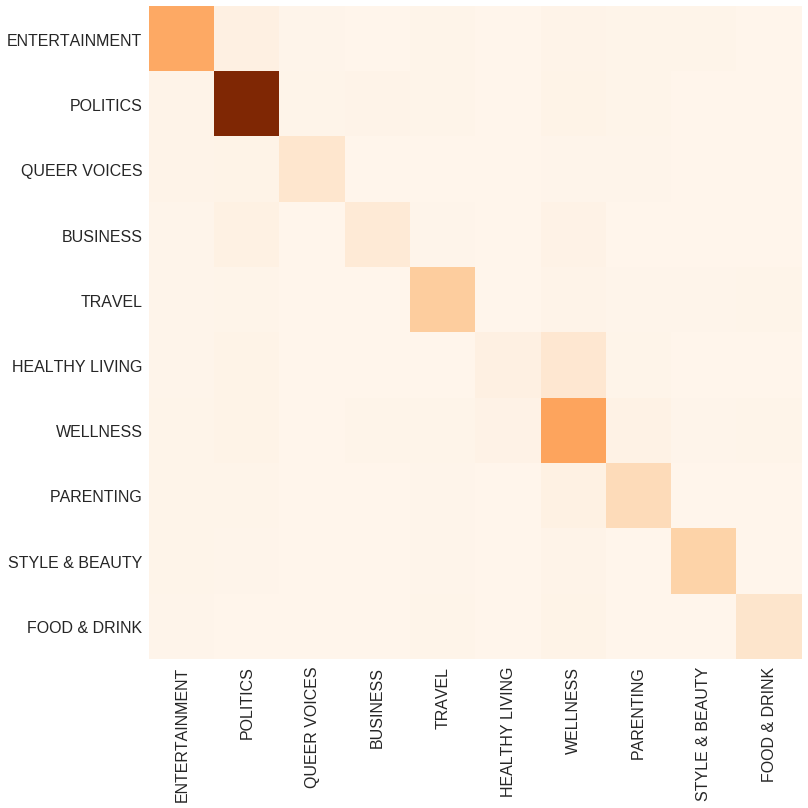

In [191]:
cnf_mx = confusion_matrix(y_test, clf_grid.best_estimator_.predict(X_test),labels=categories)
plt.figure(figsize = (12,12))
plt.imshow(cnf_mx, cmap=plt.cm.Oranges)
plt.grid(False)
plt.xticks(range(0,10),categories, rotation=90)
plt.yticks(range(0,10),categories)
plt.show()


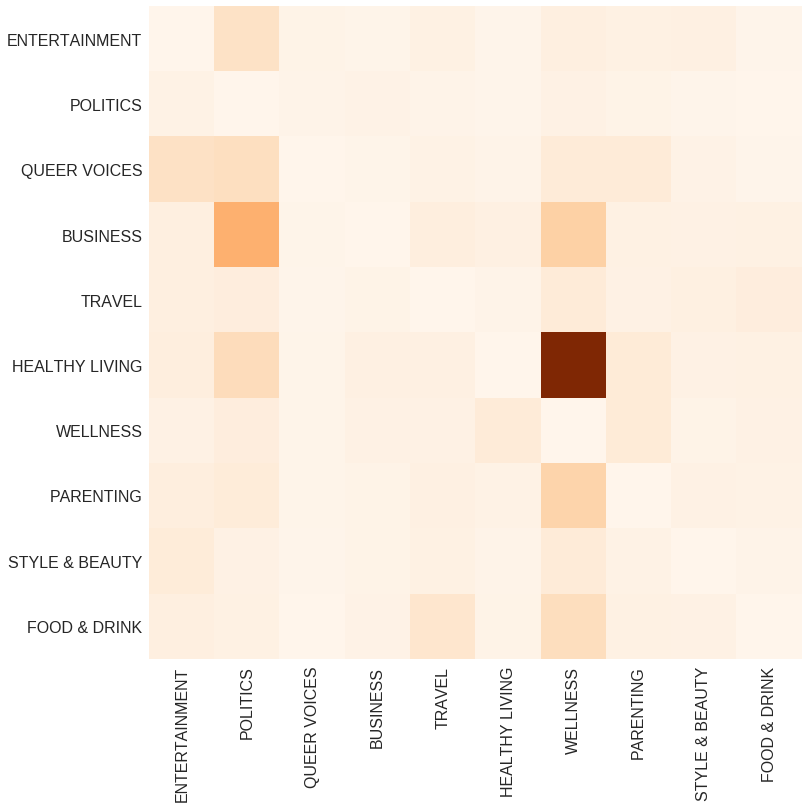

In [193]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)

plt.figure(figsize = (12,12))
plt.imshow(norm_cnf_mx, cmap=plt.cm.Oranges)
plt.grid(False)
plt.xticks(range(0,10),categories, rotation=90)
plt.yticks(range(0,10),categories)
plt.show()

This is our final calssification report for our tuned model. We see a pretty good model perfomance based on all metric. The only problematic score is the **recall** score for the BUSSINESS category which is very low compared to the same score for the remaining categories. Thus, the percentage of total relevant results correctly classified by the tuned model is $19\%$ which tells uss that our model is having a very hard time recognizing BUSSINESS news. This, I believe, has to do with what I previously conjectured as a fuzzy class, i.e. the BUSSINES category news are not as **clearly defined** as other categories which perhaps has to do with the language or the various styles in which the headline and description are written.

### Some t-sne visualization of the text data

In [147]:
X_train_sub = X_train[::15]
y_train_sub = y_train[::15]

tfid = TfidfVectorizer(analyzer = 'word', max_features = 30000,stop_words='english', lowercase =True)
X_vector = tfid.fit_transform(X_train_sub)
svd = TruncatedSVD(n_components=10, random_state=42)
X_reduced = svd.fit_transform(X1)
X_embedded2 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)
X_embedded3 = TSNE(n_components=3, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2054 samples in 0.001s...
[t-SNE] Computed neighbors for 2054 samples in 0.211s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2054
[t-SNE] Computed conditional probabilities for sample 2000 / 2054
[t-SNE] Computed conditional probabilities for sample 2054 / 2054
[t-SNE] Mean sigma: 0.043791
[t-SNE] Computed conditional probabilities in 0.180s
[t-SNE] Iteration 50: error = 73.9515991, gradient norm = 0.0562466 (50 iterations in 1.747s)
[t-SNE] Iteration 100: error = 69.7818375, gradient norm = 0.0161110 (50 iterations in 1.206s)
[t-SNE] Iteration 150: error = 69.5225143, gradient norm = 0.0042121 (50 iterations in 1.153s)
[t-SNE] Iteration 200: error = 69.5100021, gradient norm = 0.0069881 (50 iterations in 1.110s)
[t-SNE] Iteration 250: error = 69.5114365, gradient norm = 0.0032879 (50 iterations in 1.081s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.511436
[t-SNE] Iteration 300: err

In [0]:
clusters = KMeans(n_clusters=10)
labels = clusters.fit_predict(X_reduced)

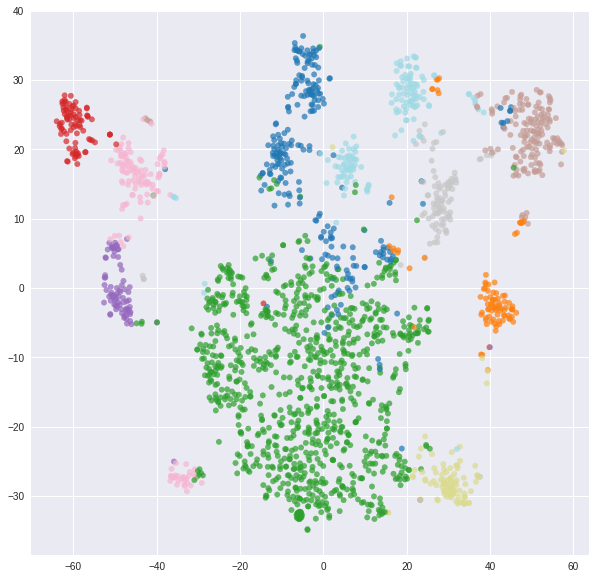

In [158]:
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded2[:, 0], X_embedded2[:, 1], c=labels, cmap='tab20', alpha=0.7, s=30)
plt.show()

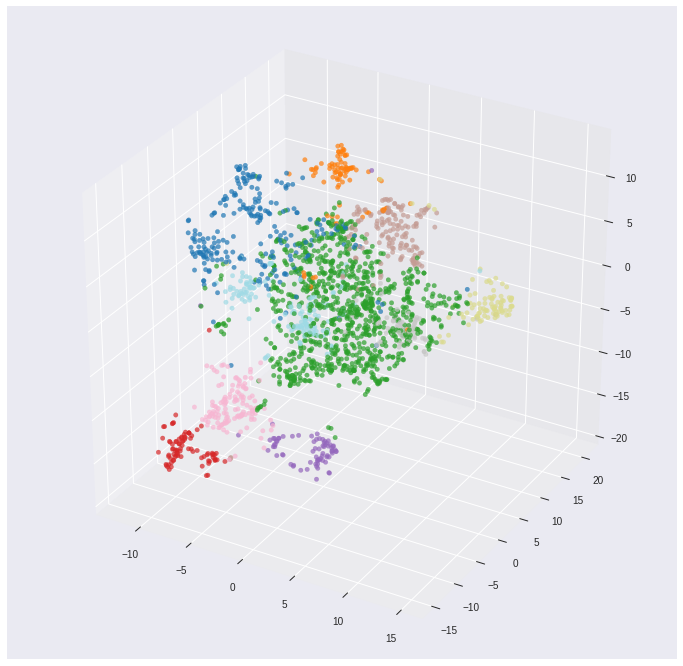

In [159]:
from mpl_toolkits import mplot3d


plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
xdata = X_embedded3[:,0]
ydata = X_embedded3[:,1]
zdata = X_embedded3[:,2]
ax.scatter3D(xdata, ydata, zdata, c=labels, cmap='tab20', alpha=0.7, s=20)
plt.show()

In the previous visualizations we can some **t-sne** embedings into 2 and 3 dimensions of the text data after the dimensionality of th data has been reduced using a truncated SVD algorithm (similar to PCA but better for sparse data) . I applied a k-means clustering algorithm to differentiate the 10 different clusters relevant in the dataset. We can appreciate some mild structure in the clustering which suggest that a classification of the news into 10 categorieswas worthwhile.

